# Multi-Fidelity Hyperparameter Optimization with Keras

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/deephyper/tutorials/blob/main/tutorials/colab/HPS_basic_classification_with_tabular_data/notebook.ipynb)

In this tutorial we present how to use hyperparameter optimization on an example from the Keras documentation. We follow the previous tutorial based on the same example and add multi-fidelity to it. The purpose of multi-fidelity is to dynamically manage the budget allocated (also called fidelity) to evaluate an hyperparameter configuration. For example, when training a deep neural network the number of epochs can be continued or stopped based on currently observed performance and some policy.

In DeepHyper, the multi-fidelity agent is designed separately from the hyperparameter search agent. Of course, both can communicate but from an API perspective they are different objects. The multi-fidelity agents are called `Stopper` in DeepHyper and their documentation can be found at [deephyper.stopper](https://deephyper.readthedocs.io/en/latest/_autosummary/deephyper.stopper.html). 

In this notebook, we will demonstrate how to use multi-fidelity inside sequential Bayesian optimization. When moving to a distributed setting, it is important to use a shared memory accessible by all workers otherwise the multi-fidelity scheme may not work properly. An example, of database instanciation for parallel computing is explained in: [Introduction to Distributed Bayesian Optimization (DBO) with MPI (Communication) and Redis (Storage)](https://deephyper.readthedocs.io/en/latest/tutorials/tutorials/scripts/02_Intro_to_DBO/README.html).

**Reference**:
 This tutorial is based on materials from the Keras Documentation: [Structured data classification from scratch](https://keras.io/examples/structured_data/structured_data_classification_from_scratch/)

Let us start with installing DeepHyper!
    
<div class="alert alert-warning">

<b>Warning</b>
    
Since the release of **Keras 3.0**, this tutorial should be run with `tf-keras` ([link to pypi](https://pypi.org/project/tf-keras/)).
    
</div>

In [10]:
try:
    import deephyper
    import deephyper.stopper.lce
    print(deephyper.__version__)
except (ImportError, ModuleNotFoundError):
    !pip install "deephyper[jax-cpu]"
    import deephyper
    import deephyper.stopper.lce
    print(deephyper.__version__)

0.9.0


<div class="alert alert-info">
    
<b>Note</b>
    
The following environment variables can be used to avoid the logging of **some** Tensorflow *DEBUG*, *INFO* and *WARNING* statements.
    
</div>

In [11]:
import os

os.environ["TF_CPP_MIN_LOG_LEVEL"] = str(4)
os.environ["AUTOGRAPH_VERBOSITY"] = str(0)

## Imports

In [12]:
import pandas as pd
import tensorflow as tf
import tf_keras as tfk
tf.get_logger().setLevel("ERROR")

## The dataset (from Keras.io)

The [dataset](https://archive.ics.uci.edu/ml/datasets/heart+Disease) is provided by the
Cleveland Clinic Foundation for Heart Disease.
It's a CSV file with 303 rows. Each row contains information about a patient (a
**sample**), and each column describes an attribute of the patient (a **feature**). We
use the features to predict whether a patient has a heart disease (**binary
classification**).

Here's the description of each feature:

Column| Description| Feature Type
------------|--------------------|----------------------
Age | Age in years | Numerical
Sex | (1 = male; 0 = female) | Categorical
CP | Chest pain type (0, 1, 2, 3, 4) | Categorical
Trestbpd | Resting blood pressure (in mm Hg on admission) | Numerical
Chol | Serum cholesterol in mg/dl | Numerical
FBS | fasting blood sugar in 120 mg/dl (1 = true; 0 = false) | Categorical
RestECG | Resting electrocardiogram results (0, 1, 2) | Categorical
Thalach | Maximum heart rate achieved | Numerical
Exang | Exercise induced angina (1 = yes; 0 = no) | Categorical
Oldpeak | ST depression induced by exercise relative to rest | Numerical
Slope | Slope of the peak exercise ST segment | Numerical
CA | Number of major vessels (0-3) colored by fluoroscopy | Both numerical & categorical
Thal | 3 = normal; 6 = fixed defect; 7 = reversible defect | Categorical
Target | Diagnosis of heart disease (1 = true; 0 = false) | Target

In [13]:
def load_data():
    file_url = "http://storage.googleapis.com/download.tensorflow.org/data/heart.csv"
    dataframe = pd.read_csv(file_url)

    val_dataframe = dataframe.sample(frac=0.2, random_state=1337)
    train_dataframe = dataframe.drop(val_dataframe.index)

    return train_dataframe, val_dataframe


def dataframe_to_dataset(dataframe):
    dataframe = dataframe.copy()
    labels = dataframe.pop("target")
    ds = tf.data.Dataset.from_tensor_slices((dict(dataframe), labels))
    ds = ds.shuffle(buffer_size=len(dataframe))
    return ds

## Preprocessing & encoding of features

The next cells use `tfk.layers.Normalization()` to apply standard scaling on the features.

Then, the `tfk.layers.StringLookup` and `tfk.layers.IntegerLookup` are used to encode categorical variables.

In [14]:
def encode_numerical_feature(feature, name, dataset):
    # Create a Normalization layer for our feature
    normalizer = tfk.layers.Normalization()

    # Prepare a Dataset that only yields our feature
    feature_ds = dataset.map(lambda x, y: x[name])
    feature_ds = feature_ds.map(lambda x: tf.expand_dims(x, -1))

    # Learn the statistics of the data
    normalizer.adapt(feature_ds)

    # Normalize the input feature
    encoded_feature = normalizer(feature)
    return encoded_feature


def encode_categorical_feature(feature, name, dataset, is_string):
    lookup_class = (
        tfk.layers.StringLookup if is_string else tfk.layers.IntegerLookup
    )
    # Create a lookup layer which will turn strings into integer indices
    lookup = lookup_class(output_mode="binary")

    # Prepare a Dataset that only yields our feature
    feature_ds = dataset.map(lambda x, y: x[name])
    feature_ds = feature_ds.map(lambda x: tf.expand_dims(x, -1))

    # Learn the set of possible string values and assign them a fixed integer index
    lookup.adapt(feature_ds)

    # Turn the string input into integer indices
    encoded_feature = lookup(feature)
    return encoded_feature

## Define the run-function with multi-fidelity

The run-function defines how the objective that we want to maximize is computed. It takes a `job` (see [deephyper.evaluator.RunningJob](https://deephyper.readthedocs.io/en/latest/_autosummary/deephyper.evaluator.RunningJob.html)) as input and outputs a scaler value or dictionnary (see [deephyper.evaluator](https://deephyper.readthedocs.io/en/latest/_autosummary/deephyper.evaluator.html)). The objective is always maximized in DeepHyper. The `job.parameters` contains a suggested configuration of hyperparameters that we want to evaluate. In this example we will search for:

* `units` (default value: `32`)
* `activation` (default value: `"relu"`)
* `dropout_rate` (default value: `0.5`)
* `batch_size` (default value: `32`)
* `learning_rate` (default value: `1e-3`)

A hyperparameter value can be acessed easily in the dictionary through the corresponding key, for example `job["units"]` or `job.parameters["units"]` are both valid. Unlike the previous tutorial in this example we want to use multi-fidelity to dynamically choose the allocated budget of each evaluation. Therefore we use the tensorflow keras integration of stoppers `deephyper.stopper.integration.TFKerasStopperCallback`. The multi-fidelity agent will monitor the validation accuracy (`val_accuracy`) in the context of maximization. This `stopper_callback` is then added to the callbacks used by the model during the training. In order to collect more information about the execution of our job we use the `@profile` decorator on the run-function which will collect execution timings (`timestamp_start` and `timestamp_end`). We will also add `"metadata"` to the output of our function to know how many epochs were used to evaluate each model. To learn more about how the `@profile` decorator can be used check our tutorial on [Understanding the pros and cons of Evaluator parallel backends](https://deephyper.readthedocs.io/en/latest/tutorials/tutorials/scripts/03_Evaluators/README.html).

```python
    stopper_callback = TFKerasStopperCallback(
        job, 
        monitor="val_accuracy", 
        mode="max"
    )
                                              
    history = model.fit(
        train_ds, 
        epochs=100, 
        validation_data=val_ds, 
        verbose=0,
        callbacks=[stopper_callback]
    )
    
    
    objective = history.history["val_accuracy"][-1]
    metadata = {"budget": stopper_callback.budget}
    return {"objective": objective, "metadata": metadata}
```

In [27]:
import json

from deephyper.evaluator import profile, RunningJob
from deephyper.stopper.integration.tf_keras2 import TFKerasStopperCallback


@profile
def run(job: RunningJob):
    
    config = job.parameters
    
    def create_and_fit_model():
        tf.autograph.set_verbosity(0)
        import absl.logging
        absl.logging.set_verbosity(absl.logging.ERROR)

        # Load data and split into validation set
        train_dataframe, val_dataframe = load_data()
        train_ds = dataframe_to_dataset(train_dataframe)
        val_ds = dataframe_to_dataset(val_dataframe)
        train_ds = train_ds.batch(config["batch_size"])
        val_ds = val_ds.batch(config["batch_size"])

        # Categorical features encoded as integers
        sex = tfk.Input(shape=(1,), name="sex", dtype="int64")
        cp = tfk.Input(shape=(1,), name="cp", dtype="int64")
        fbs = tfk.Input(shape=(1,), name="fbs", dtype="int64")
        restecg = tfk.Input(shape=(1,), name="restecg", dtype="int64")
        exang = tfk.Input(shape=(1,), name="exang", dtype="int64")
        ca = tfk.Input(shape=(1,), name="ca", dtype="int64")

        # Categorical feature encoded as string
        thal = tfk.Input(shape=(1,), name="thal", dtype="string")

        # Numerical features
        age = tfk.Input(shape=(1,), name="age")
        trestbps = tfk.Input(shape=(1,), name="trestbps")
        chol = tfk.Input(shape=(1,), name="chol")
        thalach = tfk.Input(shape=(1,), name="thalach")
        oldpeak = tfk.Input(shape=(1,), name="oldpeak")
        slope = tfk.Input(shape=(1,), name="slope")

        all_inputs = [
            sex,
            cp,
            fbs,
            restecg,
            exang,
            ca,
            thal,
            age,
            trestbps,
            chol,
            thalach,
            oldpeak,
            slope,
        ]

        # Integer categorical features
        sex_encoded = encode_categorical_feature(sex, "sex", train_ds, False)
        cp_encoded = encode_categorical_feature(cp, "cp", train_ds, False)
        fbs_encoded = encode_categorical_feature(fbs, "fbs", train_ds, False)
        restecg_encoded = encode_categorical_feature(restecg, "restecg", train_ds, False)
        exang_encoded = encode_categorical_feature(exang, "exang", train_ds, False)
        ca_encoded = encode_categorical_feature(ca, "ca", train_ds, False)

        # String categorical features
        thal_encoded = encode_categorical_feature(thal, "thal", train_ds, True)

        # Numerical features
        age_encoded = encode_numerical_feature(age, "age", train_ds)
        trestbps_encoded = encode_numerical_feature(trestbps, "trestbps", train_ds)
        chol_encoded = encode_numerical_feature(chol, "chol", train_ds)
        thalach_encoded = encode_numerical_feature(thalach, "thalach", train_ds)
        oldpeak_encoded = encode_numerical_feature(oldpeak, "oldpeak", train_ds)
        slope_encoded = encode_numerical_feature(slope, "slope", train_ds)

        all_features = tfk.layers.concatenate(
            [
                sex_encoded,
                cp_encoded,
                fbs_encoded,
                restecg_encoded,
                exang_encoded,
                slope_encoded,
                ca_encoded,
                thal_encoded,
                age_encoded,
                trestbps_encoded,
                chol_encoded,
                thalach_encoded,
                oldpeak_encoded,
            ]
        )
        x = tfk.layers.Dense(config["units"], activation=config["activation"])(
            all_features
        )
        x = tfk.layers.Dropout(config["dropout_rate"])(x)
        output = tfk.layers.Dense(1, activation="sigmoid")(x)
        model = tfk.Model(all_inputs, output)

        optimizer = tfk.optimizers.Adam(learning_rate=config["learning_rate"])
        model.compile(optimizer, "binary_crossentropy", metrics=["accuracy"])
        
        stopper_callback = TFKerasStopperCallback(
            job, 
            monitor="val_accuracy", 
            mode="max"
        )

        history = model.fit(
                train_ds, 
                epochs=100, 
                validation_data=val_ds, 
                verbose=0,
                callbacks=[stopper_callback]
            )
        return history, stopper_callback.budget

    try:
        history, budget = create_and_fit_model()        
    except:
        class History:
            history = {
                "accuracy": None,
                "val_accuracy": ["F_fit"],
                "loss": None,
                "val_loss": None,
            }

        history, budget = History(), 0
    
    
    objective = history.history["val_accuracy"][-1]
    metadata = {
        "loss": history.history["loss"],
        "val_loss": history.history["val_loss"],
        "accuracy": history.history["accuracy"],
        "val_accuracy": history.history["val_accuracy"],
    }
    metadata = {k:json.dumps(v) for k,v in metadata.items()}
    metadata["budget"] = budget
    return {"objective": objective, "metadata": metadata}

<div class="alert alert-info"> 
<b>Note</b>  
<br>

The objective maximized by DeepHyper is the `"objective"` value returned by the `run`-function.
    
</div>

In this tutorial it corresponds to the validation accuracy of the last epoch of training which we retrieve in the `History` object returned by the `model.fit(...)` call.
    
```python
...
objective = history.history["val_accuracy"][-1]
...
``` 
    
Using an objective like `max(history.history['val_accuracy'])` can have undesired side effects.

For example, it is possible that the training curves will overshoot a local maximum, resulting in a model without the capacity to flexibly adapt to new data in the future.

## Define the Hyperparameter optimization problem

Hyperparameter ranges are defined using the following syntax:

* Discrete integer ranges are generated from a tuple `(lower: int, upper: int)`
* Continuous prarameters are generated from a tuple `(lower: float, upper: float)`
* Categorical or nonordinal hyperparameter ranges can be given as a list of possible values `[val1, val2, ...]`


In [28]:
from deephyper.hpo import HpProblem


# Creation of an hyperparameter problem
problem = HpProblem()

# Discrete hyperparameter (sampled with uniform prior)
problem.add_hyperparameter((8, 128), "units", default_value=32)


# Categorical hyperparameter (sampled with uniform prior)
ACTIVATIONS = [
    "elu", "gelu", "hard_sigmoid", "linear", "relu", "selu",
    "sigmoid", "softplus", "softsign", "swish", "tanh",
]
problem.add_hyperparameter(ACTIVATIONS, "activation", default_value="relu")


# Real hyperparameter (sampled with uniform prior)
problem.add_hyperparameter((0.0, 0.6), "dropout_rate", default_value=0.5)


# Discrete and Real hyperparameters (sampled with log-uniform)
problem.add_hyperparameter((8, 256, "log-uniform"), "batch_size", default_value=32)
problem.add_hyperparameter((1e-5, 1e-2, "log-uniform"), "learning_rate", default_value=1e-3)

problem

Configuration space object:
  Hyperparameters:
    activation, Type: Categorical, Choices: {elu, gelu, hard_sigmoid, linear, relu, selu, sigmoid, softplus, softsign, swish, tanh}, Default: relu
    batch_size, Type: UniformInteger, Range: [8, 256], Default: 32, on log-scale
    dropout_rate, Type: UniformFloat, Range: [0.0, 0.6], Default: 0.5
    learning_rate, Type: UniformFloat, Range: [1e-05, 0.01], Default: 0.001, on log-scale
    units, Type: UniformInteger, Range: [8, 128], Default: 32

## Evaluate a default configuration

We evaluate the performance of the default set of hyperparameters provided in the Keras tutorial.

In [29]:
out = run(RunningJob(parameters=problem.default_configuration))

objective_default = out["output"]["objective"]
metadata_default = out["metadata"].copy()
metadata_default.update(out["output"]["metadata"])
    
print(f"Accuracy of the default configuration is {objective_default:.3f} with a budget of {metadata_default['budget']} epochs.")

out

Accuracy of the default configuration is 0.787 with a budget of 100 epochs.


{'output': {'objective': 0.7868852615356445,
  'metadata': {'loss': '[0.8586015105247498, 0.7996073365211487, 0.7143529653549194, 0.7026970982551575, 0.6131916046142578, 0.5995704531669617, 0.5482029318809509, 0.5406618714332581, 0.5241131782531738, 0.524106502532959, 0.49953699111938477, 0.48616209626197815, 0.4766983389854431, 0.4396292269229889, 0.42282265424728394, 0.4252450466156006, 0.42260438203811646, 0.40739893913269043, 0.38850900530815125, 0.39543795585632324, 0.38968002796173096, 0.3746700584888458, 0.3902652859687805, 0.34748750925064087, 0.3520696759223938, 0.37348535656929016, 0.3489677906036377, 0.3853694796562195, 0.3613702654838562, 0.34566059708595276, 0.32275688648223877, 0.2991926074028015, 0.32832810282707214, 0.3174874782562256, 0.3352506458759308, 0.31052303314208984, 0.3016624450683594, 0.3174218535423279, 0.3001049757003784, 0.320993036031723, 0.30082637071609497, 0.30680087208747864, 0.31447672843933105, 0.28569477796554565, 0.29206568002700806, 0.31954723596

## Execute Multi-Fidelity Bayesian Optimization

We create the CBO using the `problem` and `run`-function defined above. When directly passing the `run`-function to the search it is wrapped inside a [deephyper.evaluator.ThreadPoolEvaluator](https://deephyper.readthedocs.io/en/latest/_autosummary/deephyper.evaluator.ThreadPoolEvaluator.html) if the function is not defined as `async`. Then, we also import the [deephyper.stopper.SuccessiveHalvingStopper](https://deephyper.readthedocs.io/en/develop/_autosummary/deephyper.stopper.LCModelStopper.html#deephyper.stopper.SuccessiveHalvingStopper).

In [30]:
from deephyper.hpo import CBO

# Different stoppers can be used
# from deephyper.stopper import SuccessiveHalvingStopper
# from deephyper.stopper import MedianStopper
from deephyper.stopper import LCModelStopper
# from deephyper.stopper import ConstantStopper


# Instanciate the search with the problem and the evaluator that we created before

max_steps = 100
# stopper = SuccessiveHalvingStopper(max_steps=100)
# stopper = MedianStopper(max_steps=100)
stopper = LCModelStopper(max_steps=max_steps, lc_model="pow3")
# stopper = ConstantStopper(max_steps=10)

search = CBO(
    problem,
    run,
    initial_points=[problem.default_configuration],
    stopper=stopper,
    acq_optimizer="mixedga",
    acq_optimizer_freq=1,
    verbose=1,
)

<div class="alert alert-info">
    
<b>Note</b>
    
All DeepHyper's search algorithm have two stopping criteria:
    <ul> 
        <li> <code>`max_evals (int)`</code>: Defines the maximum number of evaluations that we want to perform. Default to <code>-1</code> for an infinite number.</li>
        <li> <code>`timeout (int)`</code>: Defines a time budget (in seconds) before stopping the search. Default to <code>None</code> for an infinite time budget.</li>
    </ul>
    
</div>

In [31]:
results = search.search(max_evals=100)

  0%|          | 0/100 [00:00<?, ?it/s]

The returned `results` is a Pandas Dataframe where columns starting by `"p:"` are hyperparameters, columns starting by `"m:"` are additional metadata (from the user or from the `Evaluator`) as well as the `objective` value and the `job_id`:

* `job_id` is a unique identifier corresponding to the order of creation of tasks.
* `objective` is the value returned by the run-function.
* `m:timestamp_submit` is the time (in seconds) when the task was created by the evaluator since the creation of the evaluator.
* `m:timestamp_gather` is the time (in seconds) when the task was received after finishing by the evaluator since the creation of the evaluator.
* `m:timestamp_start` is the time (in seconds) when the task started to run.
* `m:timestamp_end` is the time (in seconds) when task finished to run.
* `m:budget` is the consumed number of epoch for each evaluation.

In [32]:
results

,p:activation,p:batch_size,p:dropout_rate,p:learning_rate,p:units,objective,job_id,job_status,m:timestamp_submit,m:timestamp_start,m:timestamp_end,m:loss,m:val_loss,m:accuracy,m:val_accuracy,m:budget,m:timestamp_gather
0,relu,32,0.500000,0.001000,32,0.836066,0,DONE,1.456648,1.734356e+09,1.734356e+09,"[0.7762918472290039, 0.7172616720199585, 0.619...","[0.6589392423629761, 0.5988807678222656, 0.551...","[0.4876033067703247, 0.5537189841270447, 0.636...","[0.6557376980781555, 0.7704917788505554, 0.770...",27,20.899885
1,linear,59,0.339804,0.000041,107,0.344262,1,DONE,20.921772,1.734356e+09,1.734356e+09,"[0.8483479619026184, 0.8746565580368042, 0.855...","[0.8820262551307678, 0.8728614449501038, 0.864...","[0.39256197214126587, 0.38842976093292236, 0.3...","[0.3442623019218445, 0.3442623019218445, 0.344...",4,22.924103
2,softsign,18,0.172633,0.007230,85,0.803279,2,DONE,22.941753,1.734356e+09,1.734356e+09,"[0.46248531341552734, 0.31250038743019104, 0.2...","[0.39278772473335266, 0.43497249484062195, 0.4...","[0.7520661354064941, 0.8801652789115906, 0.884...","[0.8360655903816223, 0.8360655903816223, 0.819...",24,40.662046
3,softplus,12,0.359155,0.002343,128,0.819672,3,DONE,40.680685,1.734356e+09,1.734356e+09,"[0.6305540204048157, 0.4230377972126007, 0.357...","[0.38072243332862854, 0.3694585859775543, 0.37...","[0.6818181872367859, 0.7851239442825317, 0.830...","[0.8196721076965332, 0.8360655903816223, 0.868...",28,60.472700
4,swish,38,0.086987,0.006820,59,0.770492,4,DONE,60.490338,1.734356e+09,1.734356e+09,"[0.46736523509025574, 0.33972206711769104, 0.3...","[0.4054938852787018, 0.42384105920791626, 0.47...","[0.8057851195335388, 0.85537189245224, 0.87190...","[0.7868852615356445, 0.8196721076965332, 0.836...",28,79.979665
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,linear,19,0.447234,0.000349,98,0.770492,95,DONE,1362.685955,1.734357e+09,1.734357e+09,"[0.5967637300491333, 0.5458529591560364, 0.484...","[0.5172630548477173, 0.4642651081085205, 0.431...","[0.6859503984451294, 0.7355371713638306, 0.785...","[0.8196721076965332, 0.8032786846160889, 0.770...",4,1364.798876
96,selu,28,0.558953,0.000982,29,0.590164,96,DONE,1365.587112,1.734357e+09,1.734357e+09,"[1.0907986164093018, 0.9619468450546265]","[0.8274208903312683, 0.6619265079498291]","[0.45041322708129883, 0.46694216132164]","[0.4754098355770111, 0.5901639461517334]",2,1366.761830
97,relu,27,0.506526,0.000915,22,0.278689,97,DONE,1367.168971,1.734357e+09,1.734357e+09,[0.7771559953689575],[0.7669252157211304],[0.46694216132164],[0.2786885201931],1,1368.319722
98,selu,28,0.500093,0.000781,30,0.803279,98,DONE,1369.933016,1.734357e+09,1.734357e+09,"[0.7261590957641602, 0.5956395268440247, 0.558...","[0.5315390229225159, 0.47919774055480957, 0.44...","[0.6033057570457458, 0.7231404781341553, 0.702...","[0.8032786846160889, 0.8032786846160889, 0.803...",4,1372.021728


Now that the search is over, let us print the best configuration found during this run.

In [33]:
i_max = results.objective.argmax()
best_job = results.iloc[i_max].to_dict()


print(f"The default configuration has an accuracy of {objective_default:.3f}. \n" 
      f"The best configuration found by DeepHyper has an accuracy {results['objective'].iloc[i_max]:.3f}, \n" 
      f"discovered after {results['m:timestamp_gather'].iloc[i_max]:.2f} secondes of search.\n")

best_job

The default configuration has an accuracy of 0.787. 
The best configuration found by DeepHyper has an accuracy 0.852, 
discovered after 155.03 secondes of search.



{'p:activation': 'hard_sigmoid',
 'p:batch_size': 82,
 'p:dropout_rate': 0.4126235591467216,
 'p:learning_rate': 0.0092115321183525,
 'p:units': 66,
 'objective': 0.8524590134620667,
 'job_id': 8,
 'job_status': 'DONE',
 'm:timestamp_submit': 144.16562676429749,
 'm:timestamp_start': 1734356176.3988469,
 'm:timestamp_end': 1734356187.2655392,
 'm:loss': '[0.6404955983161926, 0.5596279501914978, 0.5096604824066162, 0.46859437227249146, 0.4367007911205292, 0.4165131747722626, 0.38263604044914246, 0.3789560794830322, 0.34091880917549133, 0.3308863341808319, 0.3304624557495117, 0.32781141996383667, 0.3071635365486145, 0.32555460929870605, 0.30638736486434937]',
 'm:val_loss': '[0.5006539821624756, 0.44969770312309265, 0.4160424768924713, 0.39829689264297485, 0.3908998966217041, 0.3828335106372833, 0.36841049790382385, 0.3579486608505249, 0.35889461636543274, 0.366230845451355, 0.3804721534252167, 0.3914380371570587, 0.40232497453689575, 0.4068129062652588, 0.4070570766925812]',
 'm:accurac

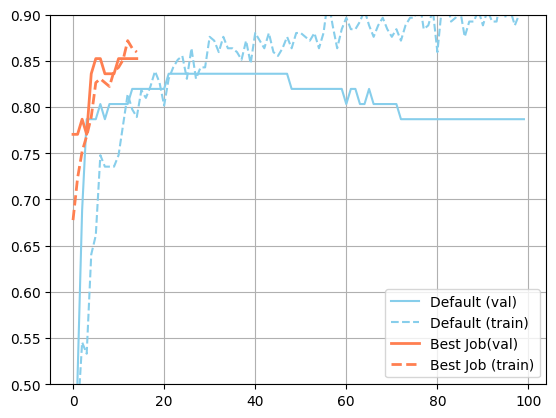

In [34]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure()
plt.plot(json.loads(metadata_default["val_accuracy"]), color="skyblue", label="Default (val)")
plt.plot(json.loads(metadata_default["accuracy"]), color="skyblue", linestyle="--", label="Default (train)")
plt.plot(json.loads(best_job["m:val_accuracy"]), color="coral", linewidth=2, label="Best Job(val)")
plt.plot(json.loads(best_job["m:accuracy"]), color="coral", linestyle="--", linewidth=2, label="Best Job (train)")
plt.legend()
plt.ylim(0.5, 0.9)
plt.grid()
plt.show()

We can observe an improvement of more than 3% in accuracy. We can retrieve the corresponding hyperparameter configuration with the number of epochs used for this evaluation (32).

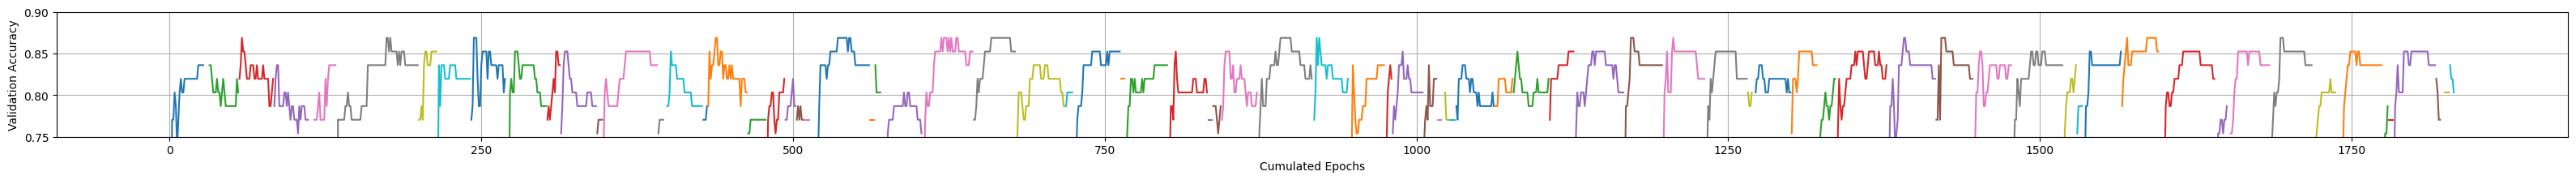

In [39]:
plt.figure(figsize=(40, 2))
cumulated_budget = 1
for i, job in results.iterrows():
    val_accuracy = json.loads(job["m:val_accuracy"])
    x = np.arange(len(val_accuracy)) + cumulated_budget
    cumulated_budget += len(val_accuracy)
    plt.plot(x, val_accuracy, label=f"Job {i}")
plt.ylabel("Validation Accuracy")
plt.xlabel("Cumulated Epochs")
plt.ylim(0.75, 0.9)
plt.grid()
plt.show()